# Displaying Text on Image in OpenCV

In [17]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

In [18]:
img = cv2.imread('./street_cam.jpg')

image dimensions: (512, 768, 3)


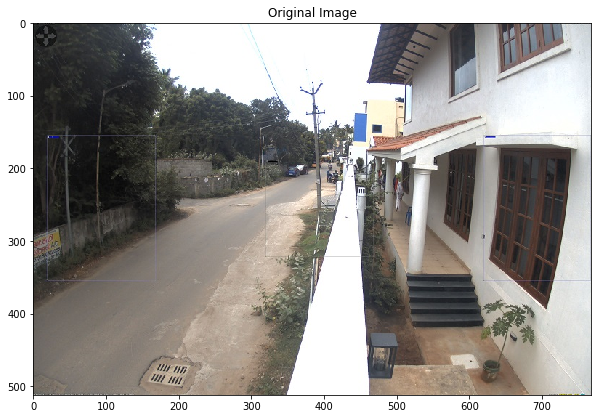

In [19]:
plt.figure(figsize=(10,10))
plt.imshow(img[:,:,::-1]);plt.title('Original Image')
print(f'image dimensions: {img.shape}')

## Naive method to display text
***Let us display text and ensure the text height is 5% of the image height***

fontScale: 1


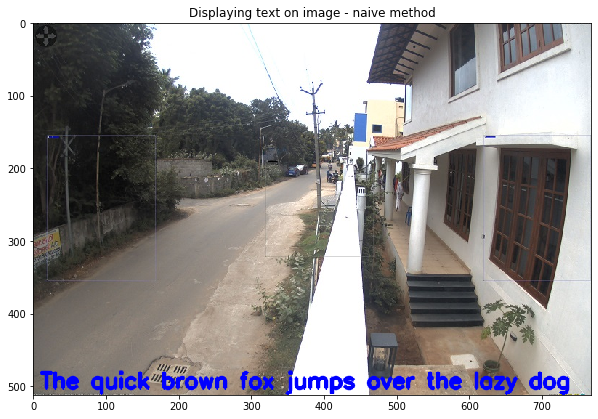

In [20]:
TEXT_HEIGHT_PERCENTAGE = 0.05
FONT_THICKNESS=3
FONT_FACE = cv2.FONT_HERSHEY_SIMPLEX
TEXT_TO_DISPLAY = 'The quick brown fox jumps over the lazy dog'
FONT_COLOR = (255, 0, 0)

text_height = int(img.shape[0]*TEXT_HEIGHT_PERCENTAGE) #5% of the image height

# Calculate the fontScale
fontScale = int(cv2.getFontScaleFromHeight(FONT_FACE, text_height, FONT_THICKNESS))
print(f"fontScale: {fontScale}")

imagewithText = img.copy()
#display text at (10,10) pixels from bottom left
cv2.putText(imagewithText, TEXT_TO_DISPLAY, (10, imagewithText.shape[0]-10), FONT_FACE, fontScale, FONT_COLOR, FONT_THICKNESS, cv2.LINE_AA);

plt.figure(figsize=(10,10))
plt.imshow(imagewithText[:,:,::-1]);plt.title('Displaying text on image - naive method');


**we can see that the text is clipped (for e.g. look at q. let us fix this**

To solve this, let us first calculate the text width and height. After that we can correctly fix the bottom left position of the text
## Correct way to display text on image

text sizes: width = 732, height = 23.
baselines: 10
TextBox Bottom Left: (18,492)


Text(0.5, 1.0, 'Image with text - no clippings, at center')

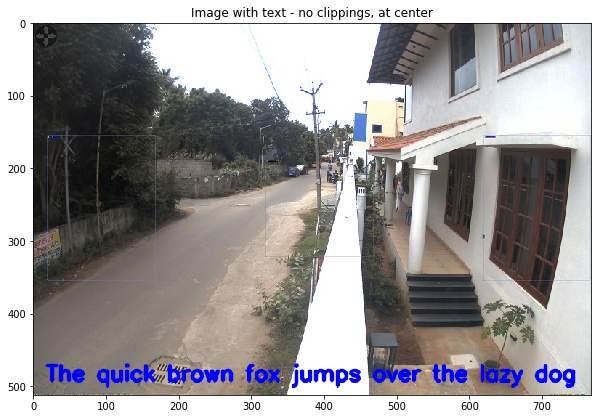

In [21]:
textSize, baseLine = cv2.getTextSize(TEXT_TO_DISPLAY, FONT_FACE, fontScale, FONT_THICKNESS)
textWidth,textHeight = textSize

print(f"text sizes: width = {textWidth}, height = {textHeight}.")
print(f"baselines: {baseLine}")

# Get the coordinates of text box bottom left corner
# The xccordinate will be such that the text is centered, ycoordinate will suchat the baseline is at 10 pixels from bottom
xcoordinate, ycoordinate = (img.shape[1] - textWidth)//2, (img.shape[0] - baseLine - 10)

print(f"TextBox Bottom Left: ({xcoordinate},{ycoordinate})")

imagewithText = img.copy()

# Finally Draw the text
cv2.putText(imagewithText, TEXT_TO_DISPLAY, (xcoordinate, ycoordinate), FONT_FACE, fontScale, FONT_COLOR, FONT_THICKNESS, cv2.LINE_AA);

plt.figure(figsize=(10,10))
plt.imshow(imagewithText[:,:,::-1]);plt.title('Image with text - no clippings, at center')

## Reversing text color based on the background color - automatically!
**Imagine you want to display text such that the text is always visible irrespective to the background.**

**This is especially required for surveillance cameras when there is significant movement**

**As you can see above the blue color is not clearly visible near the walls**

**Let us see how to display text in just the opposite color of the background, even if the background changes**

This is achieved in 3 steps
1. Extract the pixels of the text area (i.e. the pixels where text is overlaid)
2. Find out which are dark pixels and which are bright pixels in text area
3. Change Pixel values based on the pixel intensity values from text area

__Step-1: Extract text area pixels through masks__

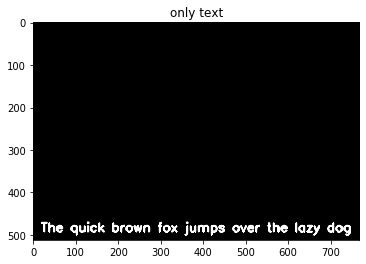

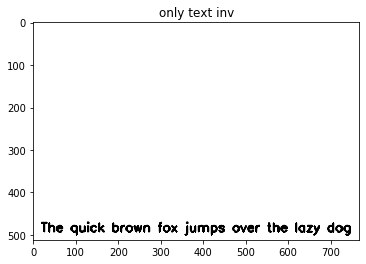

In [22]:
FONT_COLOR = (255,255,255)
rect_for_text = np.zeros_like(img)
rect_for_text_inv = 255-rect_for_text
rect_with_text = rect_for_text.copy()
rect_with_text_inv = rect_for_text_inv.copy()
cv2.putText(rect_with_text, TEXT_TO_DISPLAY, (xcoordinate, ycoordinate), FONT_FACE, fontScale, FONT_COLOR, FONT_THICKNESS, cv2.LINE_AA);
cv2.putText(rect_with_text_inv, TEXT_TO_DISPLAY, (xcoordinate, ycoordinate), FONT_FACE, fontScale, (0,0,0), FONT_THICKNESS, cv2.LINE_AA);
plt.imshow(rect_with_text[:,:,::-1]);plt.title('only text');
plt.figure()
plt.imshow(rect_with_text_inv[:,:,::-1]);plt.title('only text inv');

__step 2: Determine whether background pixels are dark or bright__

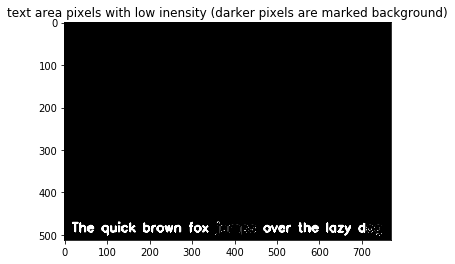

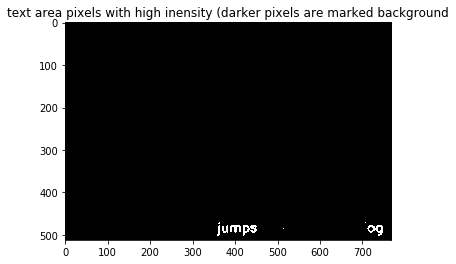

In [23]:
THRESHOLD_INTENSITY_VALUE = 200

img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
text_pixels_gray = np.bitwise_and(img_gray, rect_with_text[:,:,0])

img_high_intensity = text_pixels_gray.copy()
img_high_intensity[text_pixels_gray>THRESHOLD_INTENSITY_VALUE] = 255
img_high_intensity[text_pixels_gray<=THRESHOLD_INTENSITY_VALUE] = 0

img_low_intensity = text_pixels_gray.copy()
img_low_intensity[text_pixels_gray<=THRESHOLD_INTENSITY_VALUE] = 255
img_low_intensity[text_pixels_gray>THRESHOLD_INTENSITY_VALUE] = 0
img_low_intensity = np.bitwise_and(img_low_intensity, rect_with_text[:,:,0])

img_high_intensity_color = cv2.merge([img_high_intensity,img_high_intensity, img_high_intensity])
img_low_intensity_color = cv2.merge([img_low_intensity,img_low_intensity, img_low_intensity])
###
text_in_bright_background = np.bitwise_and(img, img_high_intensity_color)
text_in_dark_background = np.bitwise_and(img, img_low_intensity_color)

plt.imshow(img_low_intensity, cmap='gray');plt.title('text area pixels with low inensity (darker pixels are marked background)');
plt.figure();
plt.imshow(img_high_intensity, cmap='gray');plt.title('text area pixels with high inensity (darker pixels are marked background');

__step 3: Replace pixels values per brightness__

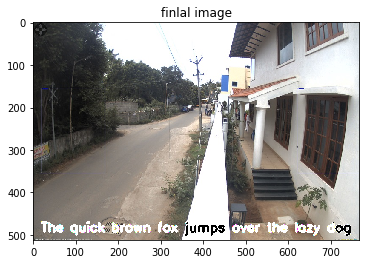

In [24]:
final_image = np.bitwise_and(img, rect_with_text_inv) #+ np.bitwise_and(text_in_bright_background, rect_with_text)+np.bitwise_and(text_in_dark_background,rect_with_text)
final_image[text_in_bright_background!=0] = 0
final_image[text_in_dark_background!=0] = 255

plt.figure();
plt.imshow(final_image[:,:,::-1]);plt.title('finlal image');

__That is it!!__

_You can see above the text above the wall (Jumps) is automatically shown in black color and so do the letters 'o' amd 'g'_